# CNN Waste Classification

### Filters based on our best model

In [54]:
efficientnet_model = torch.load('full_efficientnet_model_v3.pth', map_location=device)
efficientnet_model = efficientnet_model.to(device)
efficientnet_model.eval()

print("✅ EfficientNet model loaded and ready.")

✅ EfficientNet model loaded and ready.


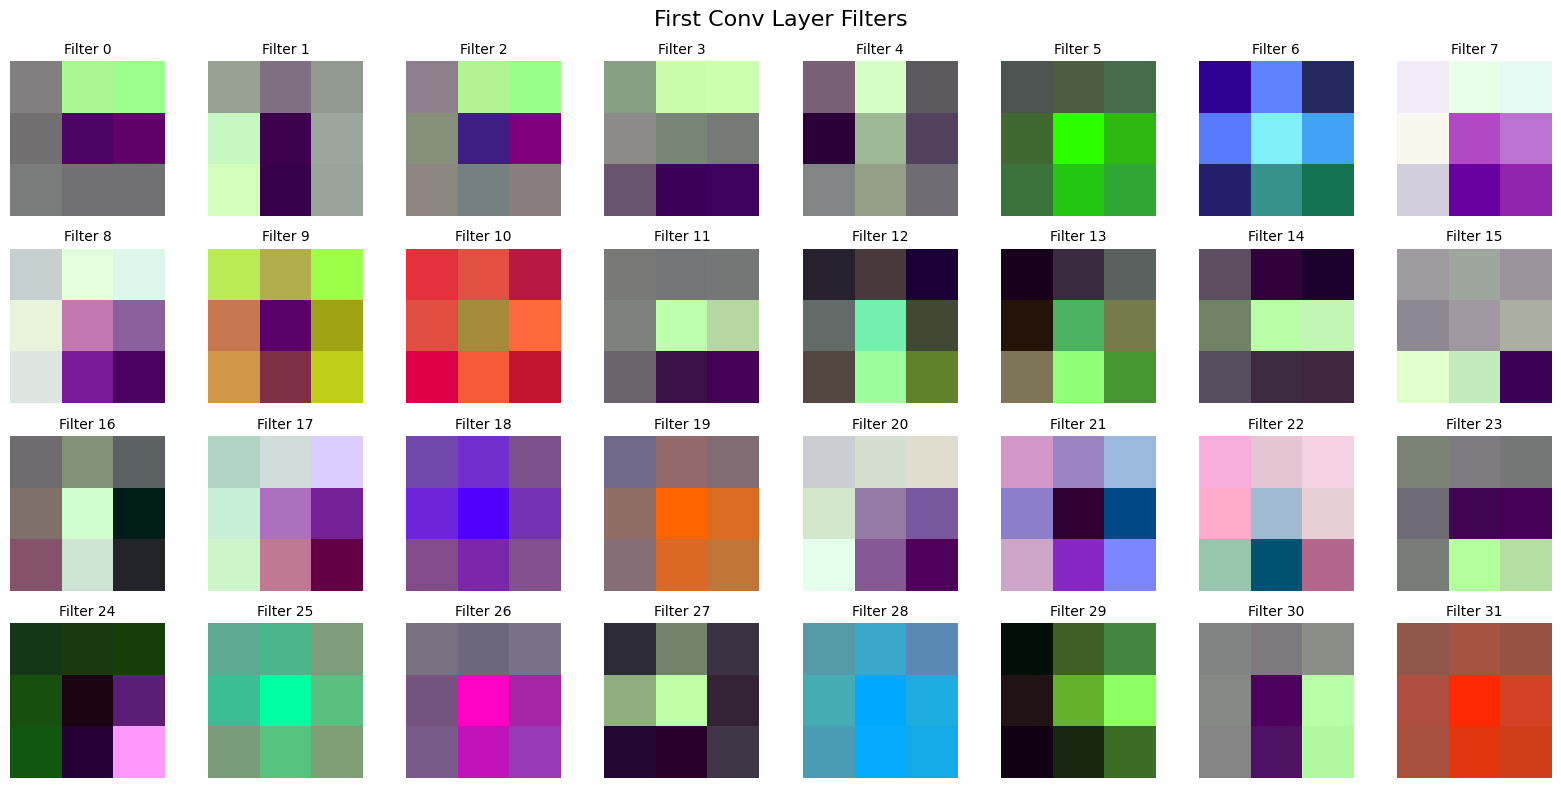

In [56]:
import matplotlib.pyplot as plt

# Access first conv layer in EfficientNet (adjust if needed)
first_conv = efficientnet_model.features[0][0]
weights = first_conv.weight.data.cpu()

# Normalize each filter individually
def normalize_tensor(t):
    return (t - t.min()) / (t.max() - t.min())

# Plot filters
num_filters = min(32, weights.shape[0])  # You can change to full set if desired
cols = 8
rows = (num_filters + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(num_filters):
    ax = axes[i]
    img = normalize_tensor(weights[i]).permute(1, 2, 0)  # Convert to [H, W, C]
    ax.imshow(img, cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Filter {i}', fontsize=10)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("First Conv Layer Filters", fontsize=16)
plt.tight_layout()
plt.show()

Using image: shoe.png


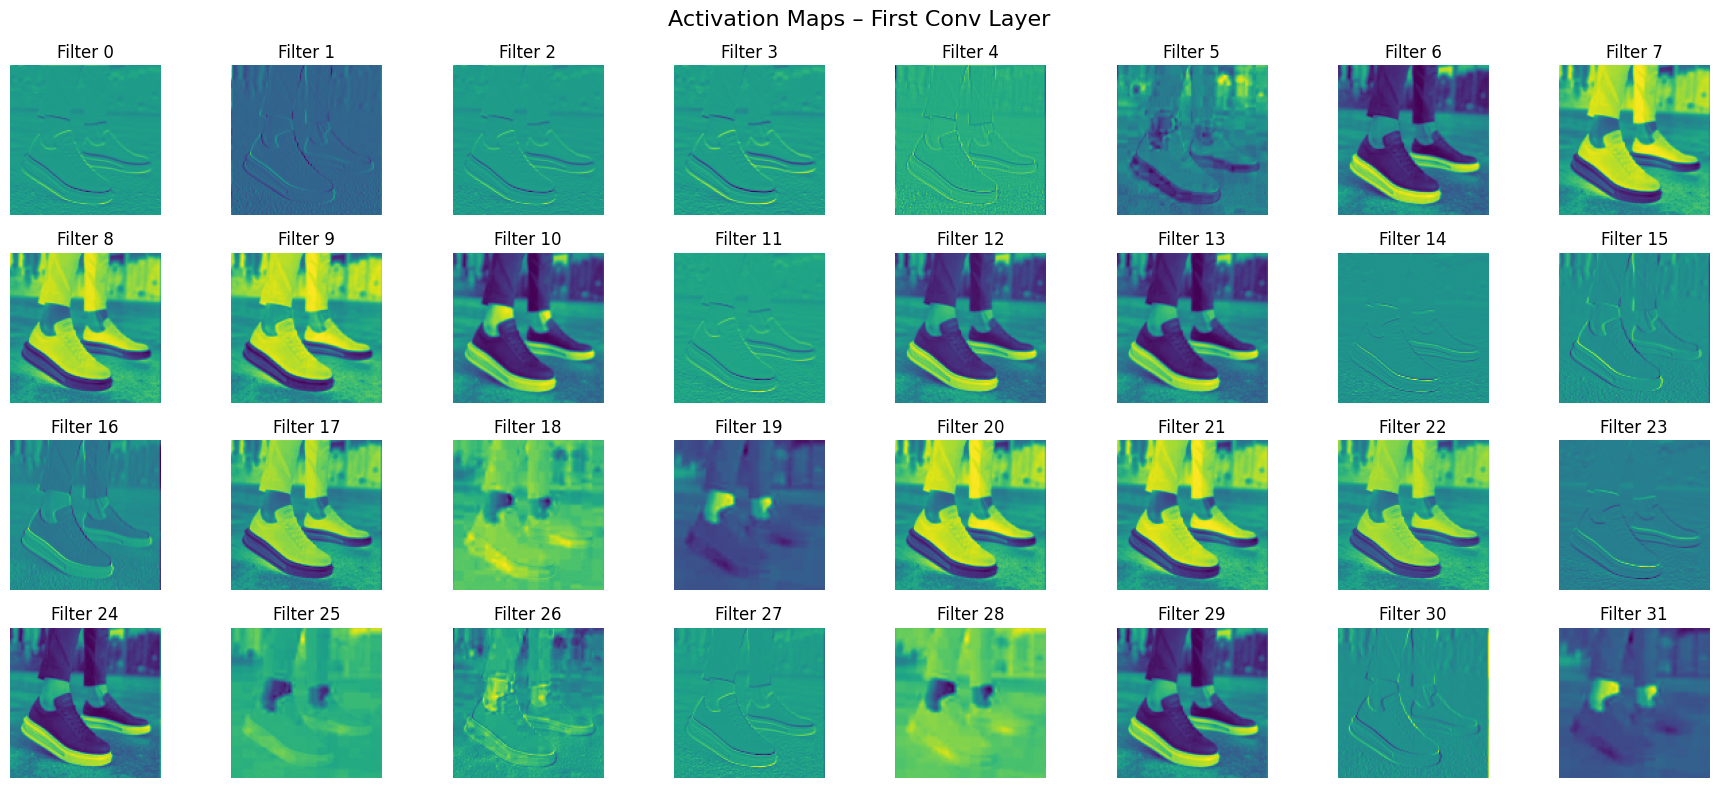

In [62]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import os

# Load your model (already done)
# efficientnet_model = torch.load('full_efficientnet_model_v3.pth', map_location=device)
# efficientnet_model.eval()

# Define transform (match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Choose a sample image (update the path as needed)
category_folder = random.choice(os.listdir('images'))
category_path = os.path.join('images', category_folder)

# 2. Pick random subfolder inside the category (default or real_world)
subfolder = random.choice(os.listdir(category_path))
subfolder_path = os.path.join(category_path, subfolder)

# 3. Pick a random image inside that subfolder
random_image = random.choice(os.listdir(subfolder_path))
# img_path = os.path.join(subfolder_path, random_image)
img_path = 'shoe.png'

print(f"Using image: {img_path}")

# 4. Open the image
img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dim

# --------
# Extract activations from first conv layer
# EfficientNet first conv layer is usually model.features[0][0] (double check)
first_conv_layer = efficientnet_model.features[0][0]

# Forward pass only through first conv layer
with torch.no_grad():
    activation = first_conv_layer(input_tensor)

# activation shape: [1, 32, H, W]
num_filters = activation.shape[1]

# Plot activation maps
fig, axes = plt.subplots(4, 8, figsize=(18, 8))
axes = axes.flatten()

for i in range(min(num_filters, len(axes))):
    ax = axes[i]
    ax.imshow(activation[0, i].cpu(), cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Filter {i}')

plt.suptitle(f"Activation Maps – First Conv Layer", fontsize=16)
plt.tight_layout()
plt.show()

## Data Pre-Processing

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
#!pip install torch -- uncomment first time you run
import seaborn as sns
#!pip install torch -- uncomment first time you run
import torch
#!pip install torchvision -- uncomment first time you run
import torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.datasets import ImageFolder

In [3]:
# Define set of transformations- convert image to PyTorch tensor, scale pixels from 0-255 to 0.0 - 1.0, normalizes pixels to -1.0 - 1.0
# Output is a (3, 256, 256) array --> Color channels 0.0 - 1.0 and the dimensions 256x256
transform_scratch = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [4]:
# Load in the dataset and apply the transform
from torchvision.datasets import ImageFolder

full_dataset = ImageFolder(root="images/", transform=transform_scratch)
print(f"Total images: {len(full_dataset)}") # Print number of images
print(f"Class labels: {full_dataset.classes}") # Print all of the class labels

Total images: 15000
Class labels: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


## Define Data Splits

-- **NOTES** --

Here we can mess around with different training splits such as 
- Random split
- Evenly divide each sub-category (Stratified)
- Evenly divide each sub-category AND default/real world images (Double Stratified)
- Train more on default images, test more on real world (Studio Train)

All of these are implemented below. Maybe we start with either random or double stratified but can test out all going forward.

In [5]:
import os
import shutil

# Paths
original_path = 'images'
grouped_path = 'grouped_dataset_6'
os.makedirs(grouped_path, exist_ok=True)

# Mapping 30 categories → 6 grouped categories
category_map = {
    'aerosol_cans': 'metal',
    'aluminum_food_cans': 'metal',
    'aluminum_soda_cans': 'metal',
    'steel_food_cans': 'metal',
    'glass_beverage_bottles': 'glass',
    'glass_cosmetic_containers': 'glass',
    'glass_food_jars': 'glass',
    'cardboard_boxes': 'paper',
    'cardboard_packaging': 'paper',
    'newspaper': 'paper',
    'magazines': 'paper',
    'office_paper': 'paper',
    'paper_cups': 'paper',
    'plastic_cup_lids': 'plastic',
    'plastic_soda_bottles': 'plastic',
    'plastic_food_containers': 'plastic',
    'plastic_water_bottles': 'plastic',
    'plastic_shopping_bags': 'plastic',
    'plastic_detergent_bottles': 'plastic',
    'plastic_straws': 'plastic',
    'plastic_trash_bags': 'plastic',
    'disposable_plastic_cutlery': 'plastic',
    'food_waste': 'organic',
    'coffee_grounds': 'organic',
    'eggshells': 'organic',
    'tea_bags': 'organic',
    'clothing': 'textile',
    'shoes': 'textile',
    'styrofoam_cups': 'textile',
    'styrofoam_food_containers': 'textile'
}

# Recursively copy all images from source folders to grouped destination folders
for original_class, grouped_class in category_map.items():
    src_folder = os.path.join(original_path, original_class)
    dst_folder = os.path.join(grouped_path, grouped_class)
    os.makedirs(dst_folder, exist_ok=True)

    for root, _, files in os.walk(src_folder):
        for img_name in files:
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                src_img_path = os.path.join(root, img_name)
                dst_img_path = os.path.join(dst_folder, f"{original_class}_{img_name}")
                shutil.copy(src_img_path, dst_img_path)

print("✅ Grouped dataset created in 'grouped_dataset_6'")

✅ Grouped dataset created in 'grouped_dataset_6'


In [7]:
from torchvision.datasets import ImageFolder

grouped_dataset = ImageFolder('grouped_dataset_6')
print("Grouped class labels:", grouped_dataset.classes)

from collections import Counter
labels = [label for _, label in grouped_dataset]
print("Class counts:", Counter(labels))

Grouped class labels: ['glass', 'metal', 'organic', 'paper', 'plastic', 'textile']
Class counts: Counter({4: 2250, 3: 1500, 1: 1000, 2: 1000, 5: 1000, 0: 751})


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
from collections import Counter
import numpy as np
import os

# STEP 1: Access original dataset if grouped_dataset is a Subset
original_dataset = grouped_dataset.dataset if isinstance(grouped_dataset, Subset) else grouped_dataset

# STEP 2: Get all paths and create combined strat labels
all_paths = [original_dataset.samples[i][0] for i in range(len(original_dataset))]
combined_labels = []
for path in all_paths:
    parts = path.split(os.sep)
    category = parts[-3]
    subtype = parts[-2]
    combined_labels.append(f"{category}__{subtype}")
combined_labels = np.array(combined_labels)

# STEP 3: Filter out labels that appear only once
label_counts = Counter(combined_labels)
valid_indices = [i for i, label in enumerate(combined_labels) if label_counts[label] > 1]
filtered_labels = combined_labels[valid_indices]

# STEP 4: Stratified split
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(split1.split(np.zeros(len(filtered_labels)), filtered_labels))

temp_labels = filtered_labels[temp_idx]
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(split2.split(np.zeros(len(temp_labels)), temp_labels))

val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

# STEP 5: Apply filtered Subset and final splits
final_dataset = Subset(original_dataset, valid_indices)

double_strat_train_dataset = Subset(final_dataset, train_idx)
double_strat_val_dataset = Subset(final_dataset, val_idx)
double_strat_test_dataset = Subset(final_dataset, test_idx)

# ✅ Sanity check
print(f"✅ Double Stratified Train size: {len(double_strat_train_dataset)}")
print(f"✅ Double Stratified Validation size: {len(double_strat_val_dataset)}")
print(f"✅ Double Stratified Test size: {len(double_strat_test_dataset)}")

✅ Double Stratified Train size: 5250
✅ Double Stratified Validation size: 1125
✅ Double Stratified Test size: 1125


### Implement Data Loader

### Sort Data into 6 Categories

In [9]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

double_strat_train_dataset.dataset.dataset.transform = transform
double_strat_val_dataset.dataset.dataset.transform = transform
double_strat_test_dataset.dataset.dataset.transform = transform

train_loader = DataLoader(double_strat_train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(double_strat_val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(double_strat_test_dataset, batch_size=32, shuffle=False)

In [10]:
print(type(double_strat_train_dataset.dataset))

<class 'torch.utils.data.dataset.Subset'>


In [11]:
print(type(double_strat_train_dataset.dataset))

<class 'torch.utils.data.dataset.Subset'>


In [12]:
# from torch.utils.data import random_split

# dataset_size = len(grouped_dataset)
# train_size = int(0.7 * dataset_size)
# val_size = int(0.15 * dataset_size)
# test_size = dataset_size - train_size - val_size

# train_dataset = double_strat_train_dataset
# val_dataset = double_strat_val_dataset
# test_dataset = double_strat_test_dataset

# batch_size = 32

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

NameError: name 'test_dataset' is not defined

In [13]:
print("Train classes:", grouped_dataset.classes)

Train classes: ['glass', 'metal', 'organic', 'paper', 'plastic', 'textile']


In [14]:
import torch.nn as nn
import torch.nn.functional as F

class StrongCustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(StrongCustomCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),     # [B, 64, 256, 256]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                             # [B, 64, 128, 128]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),   # [B, 128, 128, 128]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                             # [B, 128, 64, 64]

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # [B, 256, 64, 64]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                             # [B, 256, 32, 32]

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # [B, 512, 32, 32]
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                             # [B, 512, 16, 16]
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),                                   # [B, 512 * 16 * 16]
            nn.Dropout(0.5),
            nn.Linear(512 * 16 * 16, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [19]:
import torch
import torch.nn as nn
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = StrongCustomCNN(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 20
patience = 3
best_val_acc = 0
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.2f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⏹️ Early stopping triggered after {epoch+1} epochs (Val Acc didn't improve).")
            break

Epoch 1/20 | Train Loss: 761.78 | Train Acc: 30.13% | Val Acc: 36.53%
Epoch 2/20 | Train Loss: 260.34 | Train Acc: 36.21% | Val Acc: 37.33%
Epoch 3/20 | Train Loss: 250.67 | Train Acc: 39.39% | Val Acc: 36.27%
Epoch 4/20 | Train Loss: 248.72 | Train Acc: 41.14% | Val Acc: 45.24%
Epoch 5/20 | Train Loss: 245.22 | Train Acc: 42.99% | Val Acc: 46.22%
Epoch 6/20 | Train Loss: 244.13 | Train Acc: 43.03% | Val Acc: 44.27%
Epoch 7/20 | Train Loss: 242.43 | Train Acc: 43.79% | Val Acc: 46.40%
Epoch 8/20 | Train Loss: 239.57 | Train Acc: 44.57% | Val Acc: 45.07%
Epoch 9/20 | Train Loss: 240.97 | Train Acc: 44.61% | Val Acc: 45.60%
Epoch 10/20 | Train Loss: 239.66 | Train Acc: 44.29% | Val Acc: 47.11%
Epoch 11/20 | Train Loss: 233.95 | Train Acc: 45.35% | Val Acc: 48.36%
Epoch 12/20 | Train Loss: 233.29 | Train Acc: 45.89% | Val Acc: 46.84%
Epoch 13/20 | Train Loss: 228.54 | Train Acc: 46.23% | Val Acc: 49.16%
Epoch 14/20 | Train Loss: 225.34 | Train Acc: 46.30% | Val Acc: 47.56%
Epoch 15/20 | T

In [19]:
# Get weights of first conv layer
first_layer_weights = model.conv1.weight.data
print(first_layer_weights.shape)  # (32, 3, 3, 3)

# View weights of the last linear layer
print(model.fc2.weight.data.shape)  # (num_classes, 256)

torch.Size([32, 3, 3, 3])
torch.Size([6, 256])


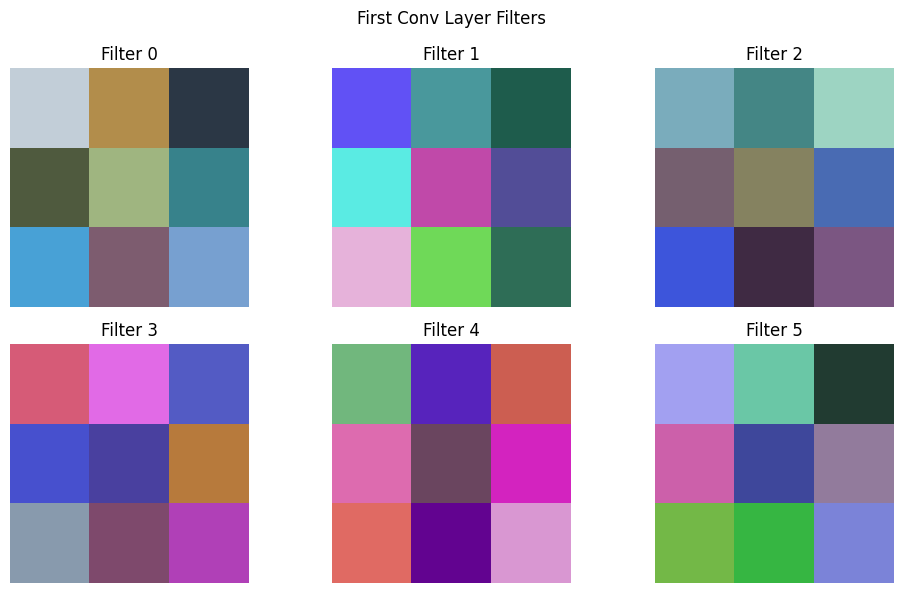

In [20]:
import matplotlib.pyplot as plt

# Get weights from the first conv layer (shape: [out_channels, in_channels, H, W])
weights = model.conv1.weight.data.cpu()

# Normalize weights for visualization
weights_min = weights.min()
weights_max = weights.max()
weights = (weights - weights_min) / (weights_max - weights_min)

# Plot the first 6 filters (you can increase this)
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    if i >= weights.shape[0]:
        break
    # Select RGB channels and move channels to last dim (for matplotlib)
    img = weights[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(f"Filter {i}")
    ax.axis("off")

plt.suptitle("First Conv Layer Filters")
plt.tight_layout()
plt.show()

In [23]:
torch.save(model.state_dict(), 'best_model6.pt')

Using image: images/styrofoam_cups/default/Image_148.png


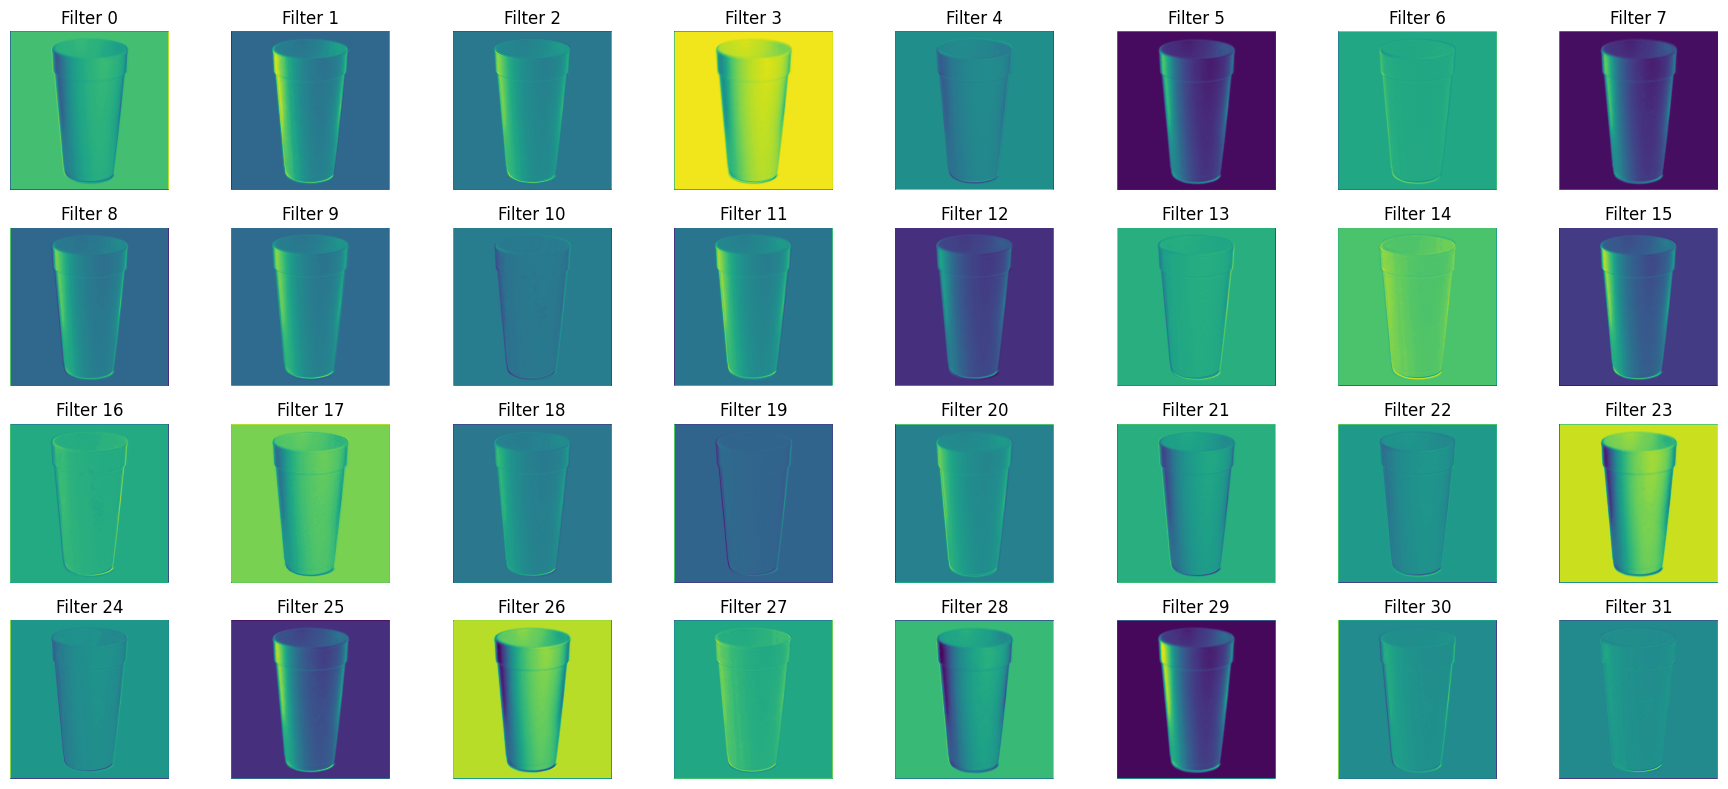

In [34]:
import os
import random
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

# 1. Pick a random category folder (e.g., plastic_cup_lids)
category_folder = random.choice(os.listdir('images'))
category_path = os.path.join('images', category_folder)

# 2. Pick random subfolder inside the category (default or real_world)
subfolder = random.choice(os.listdir(category_path))
subfolder_path = os.path.join(category_path, subfolder)

# 3. Pick a random image inside that subfolder
random_image = random.choice(os.listdir(subfolder_path))
img_path = os.path.join(subfolder_path, random_image)

print(f"Using image: {img_path}")

# 4. Open the image
img = Image.open(img_path).convert('RGB')

# 5. Preprocess the image (NO data augmentation!)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

input_tensor = transform(img).unsqueeze(0)

# 6. Load model
model = StrongCustomCNN(num_classes=6)
model.load_state_dict(torch.load('best_model6.pt'))
model.eval()

first_layer = model.features[0]

# 7. Get activations
with torch.no_grad():
    activations = first_layer(input_tensor)

# 8. Visualize activations
fig, axes = plt.subplots(4, 8, figsize=(18, 8))
axes = axes.flatten()

for i in range(32):
    ax = axes[i]
    act = activations[0, i].cpu()
    ax.imshow(act, cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Filter {i}')

plt.tight_layout()
plt.show()

Using image: images/plastic_cup_lids/default/Image_12.png


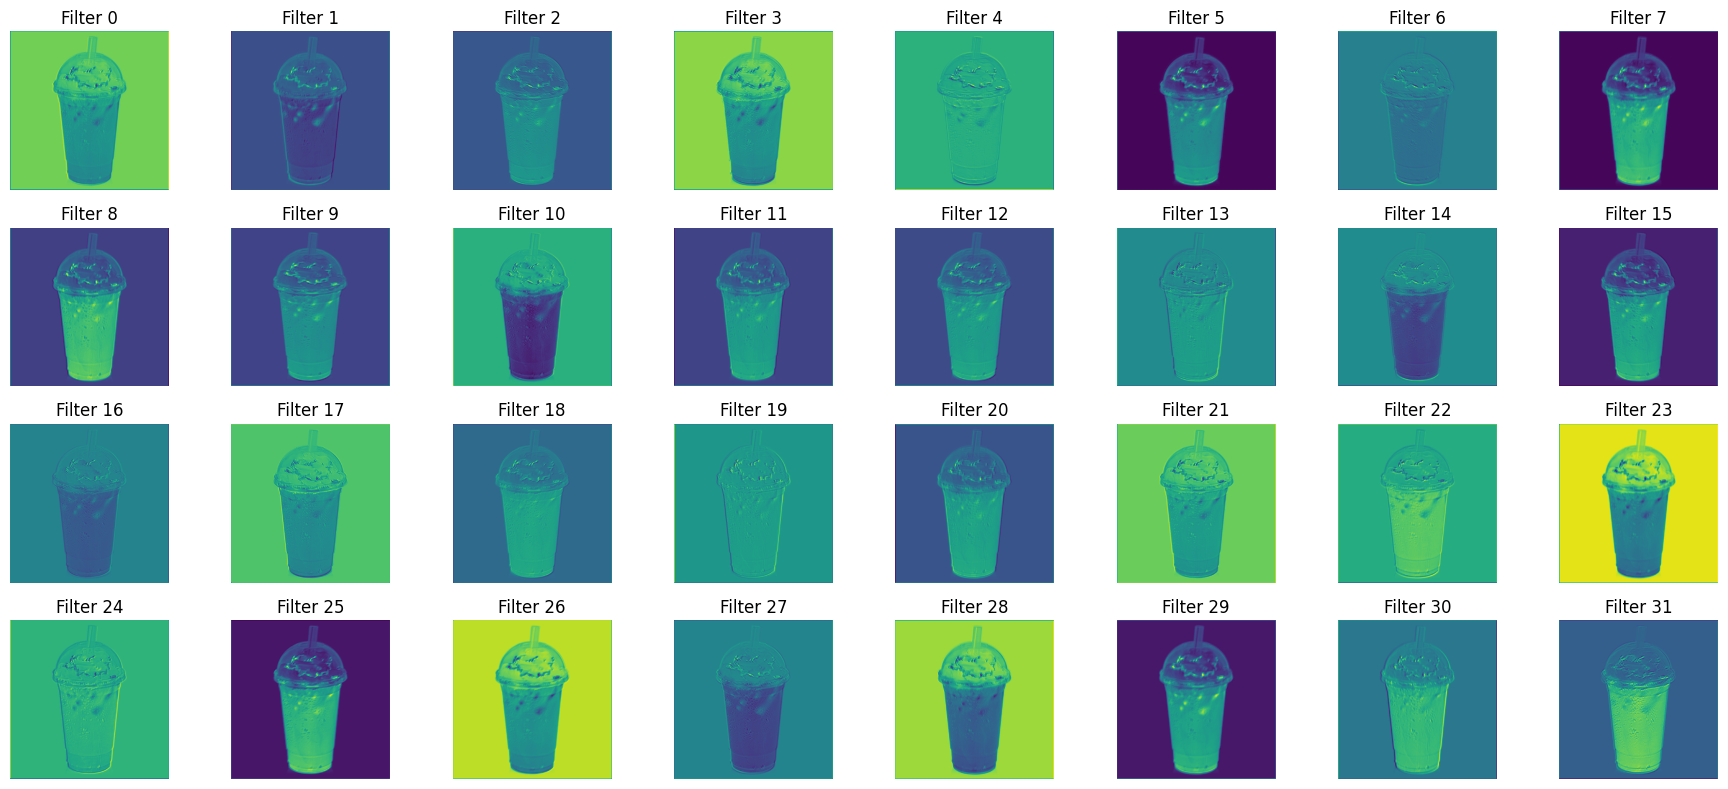

In [50]:
import os
import random
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

# 1. Pick a random category folder (e.g., plastic_cup_lids)
category_folder = random.choice(os.listdir('images'))
category_path = os.path.join('images', category_folder)

# 2. Pick random subfolder inside the category (default or real_world)
subfolder = random.choice(os.listdir(category_path))
subfolder_path = os.path.join(category_path, subfolder)

# 3. Pick a random image inside that subfolder
random_image = random.choice(os.listdir(subfolder_path))
img_path = os.path.join(subfolder_path, random_image)

print(f"Using image: {img_path}")

# 4. Open the image
img = Image.open(img_path).convert('RGB')

# 5. Preprocess the image (NO data augmentation!)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

input_tensor = transform(img).unsqueeze(0)

# 6. Load model
model = StrongCustomCNN(num_classes=6)
model.load_state_dict(torch.load('best_model6.pt'))
model.eval()

first_layer = model.features[0]

# 7. Get activations
with torch.no_grad():
    activations = first_layer(input_tensor)

# 8. Visualize activations
fig, axes = plt.subplots(4, 8, figsize=(18, 8))
axes = axes.flatten()

for i in range(32):
    ax = axes[i]
    act = activations[0, i].cpu()
    ax.imshow(act, cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Filter {i}')

plt.tight_layout()
plt.show()

Using image: images/tea_bags/default/Image_236.png


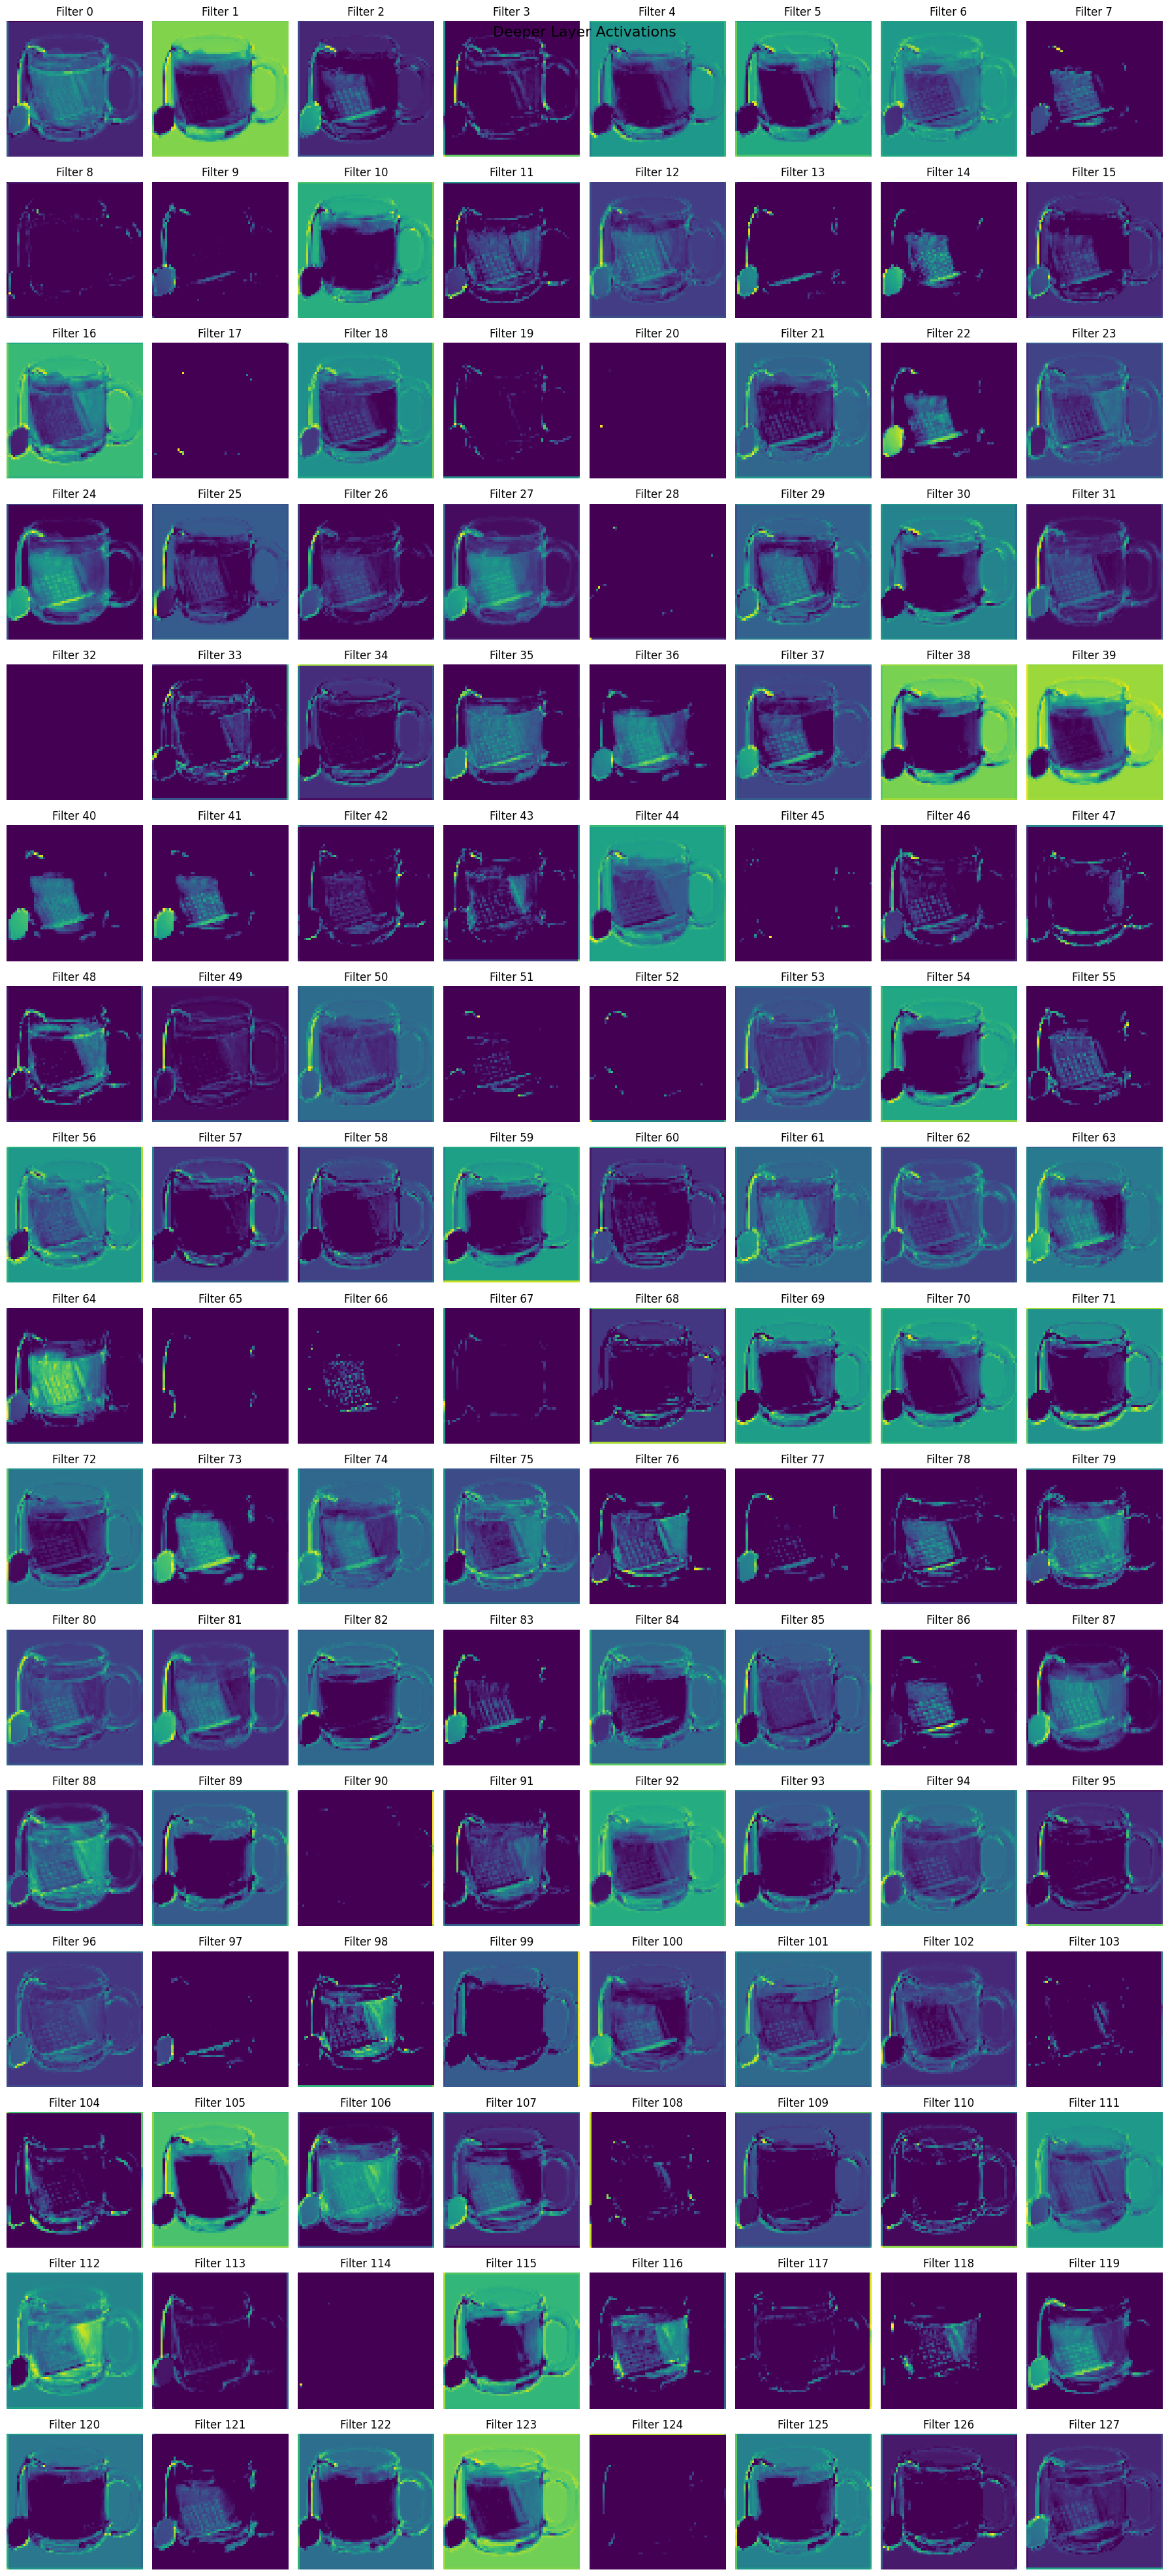

In [49]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as transforms

# Load the image
img_path = 'images/tea_bags/default/Image_236.png'  # update path as needed
print(f"Using image: {img_path}")
img = Image.open(img_path).convert('RGB')

# Preprocess (no augmentation)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
input_tensor = transform(img).unsqueeze(0)  # add batch dimension

# Load model
model = StrongCustomCNN(num_classes=6)
model.load_state_dict(torch.load('best_model6.pt'))
model.eval()

# Choose deeper layer (e.g., layer after second MaxPool)
with torch.no_grad():
    x = input_tensor
    for i in range(8):  # step into deeper layer (index 8 = after 2nd MaxPool)
        x = model.features[i](x)
    activations = x

# Visualize
num_filters = activations.shape[1]
cols = 8
rows = (num_filters + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 2.5 * rows))
axes = axes.flatten()

for i in range(num_filters):
    ax = axes[i]
    ax.imshow(activations[0, i].cpu(), cmap='viridis')
    ax.set_title(f"Filter {i}")
    ax.axis('off')

# Hide unused subplots
for i in range(num_filters, len(axes)):
    axes[i].axis('off')

plt.suptitle("Deeper Layer Activations", fontsize=16)
plt.tight_layout()
plt.show()

In [52]:
efficientnet_model = torch.load('full_efficientnet_model_v3.pth', map_location=device)
efficientnet_model = efficientnet_model.to(device)
efficientnet_model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import numpy as np

# Load your model
model = WasteClassifierCNN(num_classes=6)
model.load_state_dict(torch.load('best_model6.pt'))  # <-- adjust if needed
model.eval()

# Load your image
img_path = 'your_image_here.jpg'  # <-- Replace with an actual image path
img = Image.open(img_path).convert('RGB')

# Preprocessing (no heavy augmentation)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Forward pass through the first conv layer only
first_layer = model.conv1
with torch.no_grad():
    activations = first_layer(input_tensor)

# Pick a few interesting filters (say, the ones that light up most)
# For simplicity let's just pick the first 6 filters
filters_to_visualize = [0, 1, 2, 3, 4, 5]

# Reverse normalization to get the original image for overlay
reverse_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.5]*3),
    transforms.Normalize(mean=[-0.5]*3, std=[1.]*3)
])

original_img = reverse_transform(input_tensor.squeeze(0)).permute(1, 2, 0).numpy()
original_img = np.clip(original_img, 0, 1)  # Clip to valid range

# Plot overlays
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, filter_idx in enumerate(filters_to_visualize):
    activation = activations[0, filter_idx].cpu().numpy()
    activation = (activation - activation.min()) / (activation.max() - activation.min())  # Normalize to 0-1

    ax = axes[idx]
    ax.imshow(original_img)  # Show the original image
    ax.imshow(activation, cmap='plasma', alpha=0.5)  # Overlay activation
    ax.axis('off')
    ax.set_title(f"Overlay of Filter {filter_idx}")

plt.tight_layout()
plt.show()

In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"\n✅ Final Test Accuracy: {test_acc:.2f}%")

NameError: name 'model' is not defined

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  # Make sure test_loader is from grouped_dataset_6
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

In [15]:
print(len(cm))                         # Should be 6
print(len(grouped_dataset.classes))    # Should also be 6 ✅

6
6


In [53]:
print(test_loader.dataset.dataset.root)

grouped_dataset_6


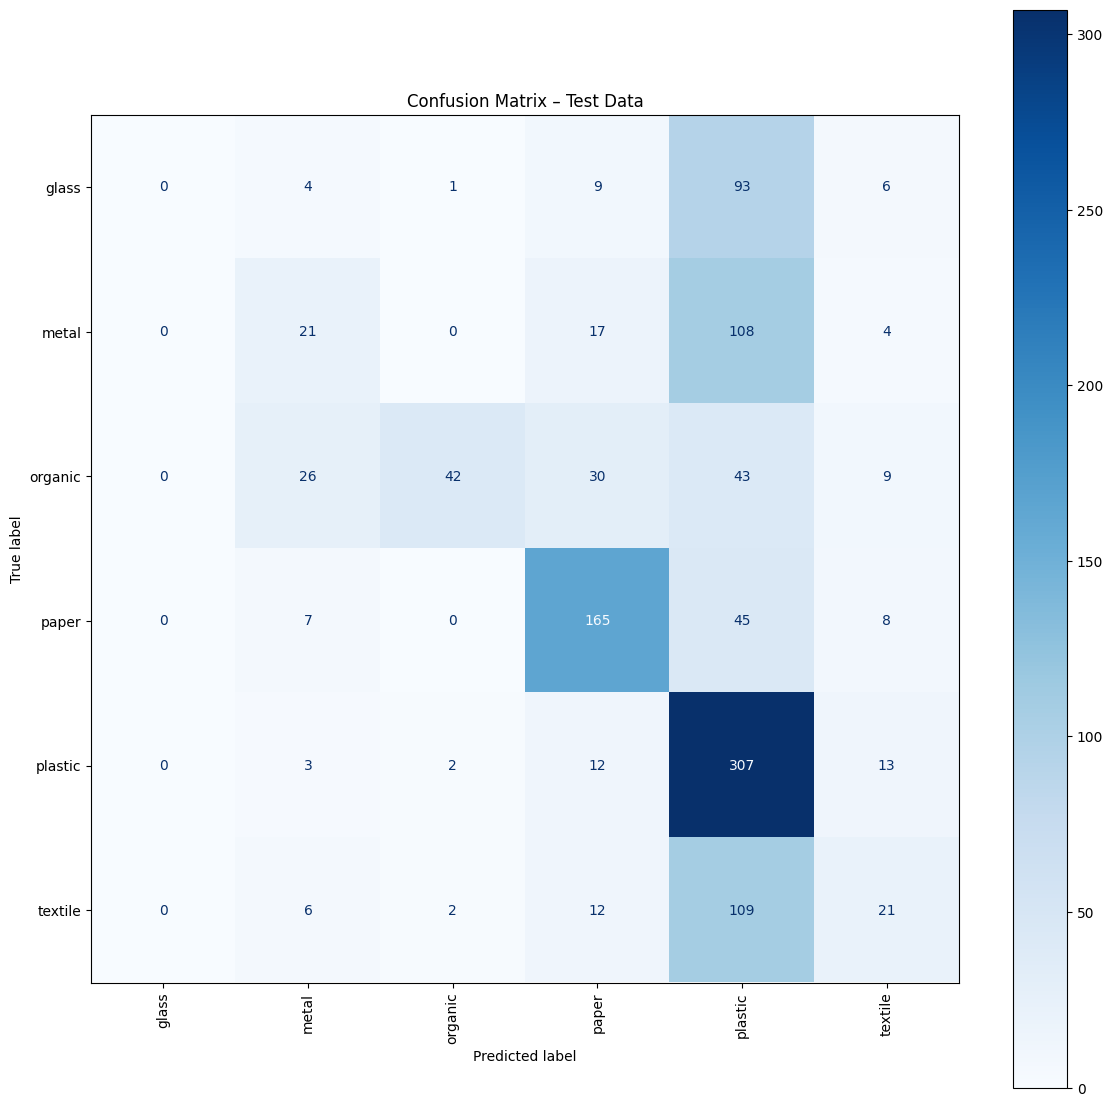

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grouped_dataset.classes)




fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix – Test Data")
plt.show()

### Double strat split, transfer learning model based on 6 groups 

In [25]:
!pip install tqdm

Using device: cpu

Epoch 1/20


→ Train Loss: 1.6384 | Val Loss: 1.4773

Epoch 2/20


→ Train Loss: 1.4204 | Val Loss: 1.3142

Epoch 3/20


→ Train Loss: 1.2407 | Val Loss: 1.2694

Epoch 4/20


→ Train Loss: 1.0676 | Val Loss: 1.1331

Epoch 5/20


→ Train Loss: 0.8445 | Val Loss: 1.1006

Epoch 6/20


→ Train Loss: 1.0554 | Val Loss: 1.1608

Epoch 7/20


→ Train Loss: 0.9264 | Val Loss: 1.0166

Epoch 8/20


→ Train Loss: 0.8461 | Val Loss: 1.0557

Epoch 9/20


→ Train Loss: 0.8129 | Val Loss: 0.9968

Epoch 10/20


→ Train Loss: 0.7200 | Val Loss: 1.0480

Epoch 11/20


→ Train Loss: 0.6634 | Val Loss: 1.0004

Epoch 12/20


→ Train Loss: 0.6239 | Val Loss: 1.1649
Early stopping triggered after 12 epochs.


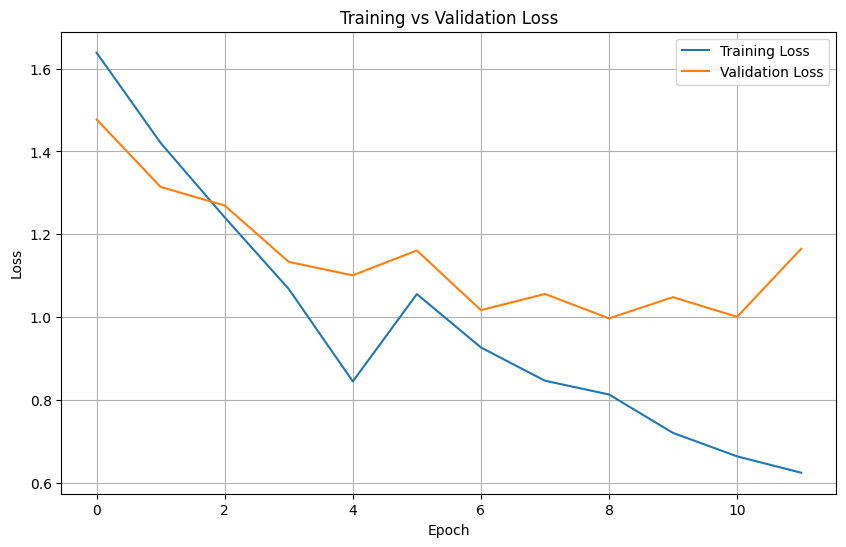

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os

# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# TRANSFORMS
# ----------------------
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

transform_plain = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# ----------------------
# DATASET LOADING (6-CLASS)
# ----------------------
grouped_dataset = ImageFolder("grouped_dataset_6", transform=transform_plain)

# Use precomputed double stratified indices
train_idx = double_strat_train_dataset.indices
val_idx = double_strat_val_dataset.indices

# ----------------------
# MODEL DEFINITION
# ----------------------
class WasteClassifierCNN6(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN6, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ----------------------
# INITIALIZATION
# ----------------------
num_classes = len(grouped_dataset.classes)
model = WasteClassifierCNN6(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# ----------------------
# TRAINING LOOP
# ----------------------
num_epochs = 20
patience = 3
best_val_loss = float('inf')
patience_counter = 0
history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    grouped_dataset.transform = transform_augmented if epoch >= 5 else transform_plain

    train_loader = DataLoader(Subset(grouped_dataset, train_idx), batch_size=32, shuffle=True)
    val_loader = DataLoader(Subset(grouped_dataset, val_idx), batch_size=32, shuffle=False)

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    train_loss = running_loss / len(train_loader)
    history["loss"].append(train_loss)

    # ----------------------
    # VALIDATION
    # ----------------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)
    print(f"\u2192 Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ----------------------
    # EARLY STOPPING
    # ----------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_6class.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# ----------------------
# PLOT LOSS CURVES
# ----------------------
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"\n✅ Final Test Accuracy: {test_acc:.2f}%")


✅ Final Test Accuracy: 74.67%


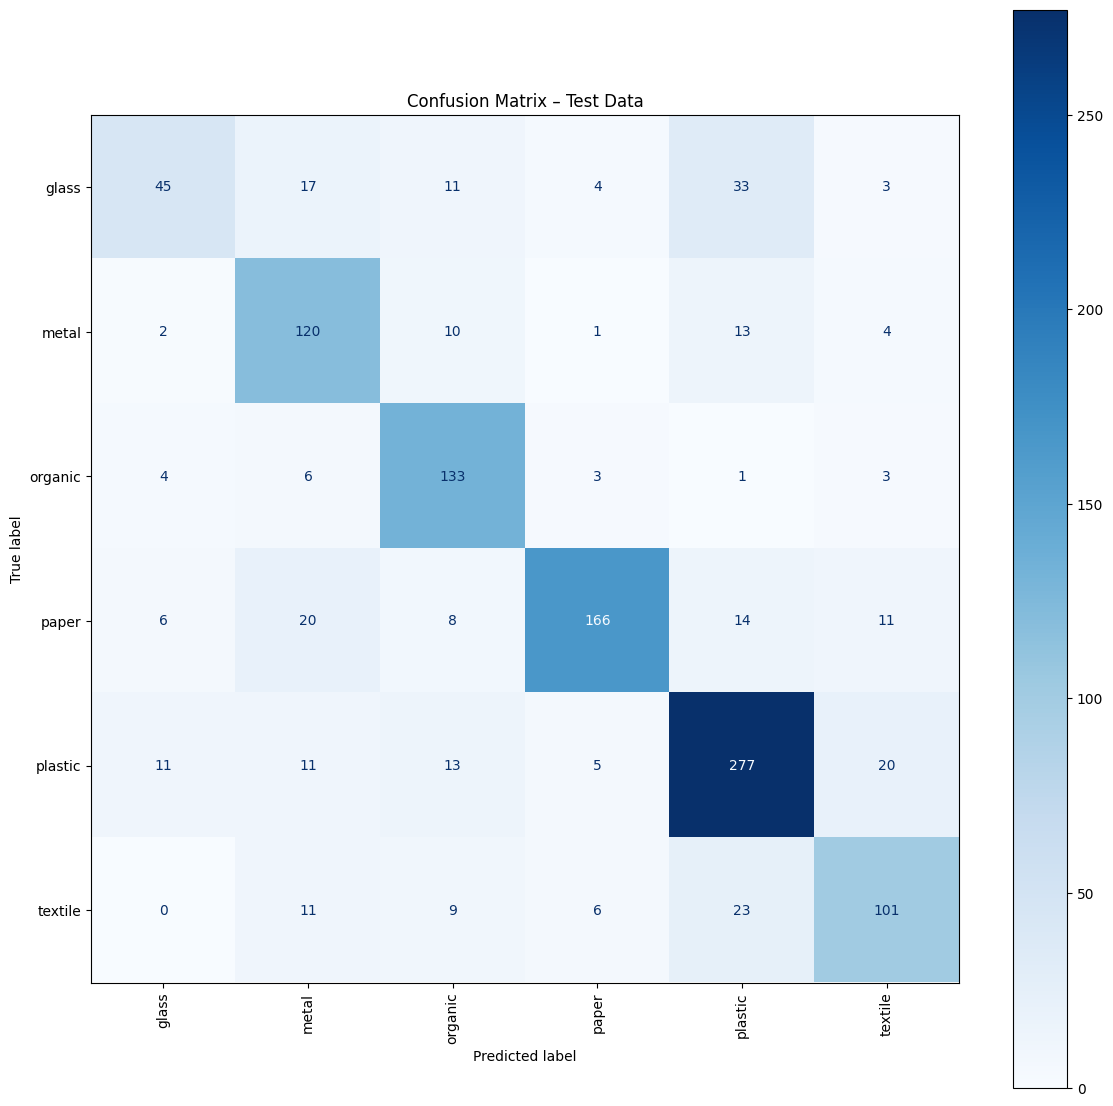

In [18]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grouped_dataset.classes)




fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix – Test Data")
plt.show()

## Custom CNN on the 30 categories

In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
#!pip install tensorflow matplotlib scikit-learn

In [5]:
from torch.utils.data import random_split

# 80-20 split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [6]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # Placeholder for fc1 — we'll initialize it after knowing the flatten size
        self._flattened_size = None
        self.fc1 = None
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)

        # Initialize fc1 if we haven't yet
        if self.fc1 is None:
            self._flattened_size = x.shape[1]
            self.fc1 = nn.Linear(self._flattened_size, 128).to(x.device)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [8]:
num_classes = len(full_dataset.classes)
model = WasteClassifierCNN(num_classes)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 7

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%")

Epoch 1, Loss: 1065.459, Train Accuracy: 20.75%
Epoch 2, Loss: 1026.542, Train Accuracy: 23.36%
Epoch 3, Loss: 1002.822, Train Accuracy: 24.92%
Epoch 4, Loss: 979.822, Train Accuracy: 26.45%
Epoch 5, Loss: 963.695, Train Accuracy: 27.52%
Epoch 6, Loss: 945.578, Train Accuracy: 28.23%
Epoch 7, Loss: 928.535, Train Accuracy: 30.22%


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# try doing random and double stratified data splits 

Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.20      0.09      0.12       110
        aluminum_food_cans       0.26      0.16      0.19       116
        aluminum_soda_cans       0.29      0.21      0.25       103
           cardboard_boxes       0.38      0.56      0.45       113
       cardboard_packaging       0.33      0.18      0.23       106
                  clothing       0.35      0.30      0.32       105
            coffee_grounds       0.52      0.80      0.63        85
disposable_plastic_cutlery       0.34      0.17      0.23        94
                 eggshells       0.29      0.23      0.26       100
                food_waste       0.33      0.62      0.43        99
    glass_beverage_bottles       0.34      0.43      0.38       102
 glass_cosmetic_containers       0.24      0.33      0.28        99
           glass_food_jars       0.38      0.37      0.38       100
                 magazin